# As supervised problem - NLP

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
import nltk

nltk.download('gutenberg')
!python -m spacy download en


[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\femis\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
symbolic link created for C:\Users\femis\Anaconda3\lib\site-packages\spacy\data\en <<===>> C:\Users\femis\Anaconda3\lib\site-packages\en_core_web_sm
[+] Linking successful
C:\Users\femis\Anaconda3\lib\site-packages\en_core_web_sm -->
C:\Users\femis\Anaconda3\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


Supervised NLP requires a pre-labelled dataset for training and testing, and is generally interested in categorizing text in various ways. In this case, we are going to try to PREDICT whether a sentence comes from Alice in Wonderland by Lewis Carroll or Persuasion by Jane Austen. We can use any of the supervised models we've covered previously, as long as they allow categorical outcomes. In this case, we'll try RANDOM FORESTS, SVM, and KNN.

Our FEATURE-GENERATION approach will be something called BoW, or Bag of Words. BoW is quite simple: For each sentence, we count how many times each word appears. We will then use those counts as features.

Note: Since processing all the text takes around ~5-10 minutes, in the cell below we are taking only the first tenth of each text. If you want to experiment, feel free to change the following code in the next cell:

alice = text_cleaner(alice[:int(len(alice)/10)])

persuasion = text_cleaner(persuasion[:int(len(persuasion)/10)])

to

alice = text_cleaner(alice)

persuasion = text_cleaner(persuasion)

In [4]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice[:int(len(alice)/10)])
persuasion = text_cleaner(persuasion[:int(len(persuasion)/10)])

In [5]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [6]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents)
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(Oh, dear, !)",Carroll


Time to bag some words! Since spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur. We will exclude stopwords and punctuation. In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

In [7]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [8]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400


,farther,propose,judge,reserve,volume,horribly,stop,ball,breeding,far,...,originally,regular,alarm,wear,public,admit,rejoice,perfection,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll


In [59]:
word_counts["text_source"] = word_counts["text_source"].astype('int64')

word_counts.dtypes


farther            object
propose            object
judge              object
reserve            object
volume             object
horribly           object
stop               object
ball               object
breeding           object
far                object
history            object
poor               object
particularly       object
comprehensive      object
undesirableness    object
surprised          object
perpetuate         object
intimate           object
present            object
quarter            object
right              object
disposed           object
shortly            object
involve            object
sir                object
worth              object
father             object
prefer             object
easily             object
conduct            object
                    ...  
size               object
letter             object
tiding             object
keep               object
curious            object
near               object
dictate            object
20          

In [56]:

word_counts["text_source_cat"] = word_counts["text_source"].cat.codes

word_counts.head()

,farther,propose,judge,reserve,volume,horribly,stop,ball,breeding,far,...,regular,alarm,wear,public,admit,rejoice,perfection,text_sentence,text_source,text_source_cat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(Oh, dear, !)",1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"(Oh, dear, !)",1,0


## BoW with Random Forest

Now let's give the bag of words features a whirl by trying a random forest.

In [78]:

from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
y = word_counts['text_source_cat']

X = np.array(word_counts.drop(['text_sentence','text_source','text_source_cat'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\Users\femis\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9736842105263158

Test set score: 0.8539325842696629


Holy overfitting, Batman! Overfitting is a known problem when using bag of words, since it basically involves throwing a massive number of features at a model – some of those features (in this case, word frequencies) will capture noise in the training set. Since overfitting is also a known problem with Random Forests, the divergence between training score and test score is expected.



## SVM

In [61]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X,Y)

C:\Users\femis\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

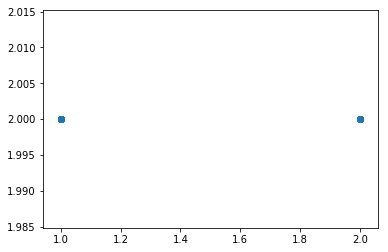

In [62]:
# Let's see what a scatter plot looks like, comparing actuals to predicted.

plt.scatter(Y, svc.predict(X))

In [63]:
#  scores of both our full fit model and with cross validation
svc.score(X, Y)

0.7094594594594594

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(svc, X, Y, cv=5)

C:\Users\femis\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\femis\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\femis\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\femis\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

array([0.70786517, 0.70786517, 0.70786517, 0.70786517, 0.71590909])

### Linear SVM

In [21]:
# Instantiate our model and fit the data.
svm = SVC(kernel = 'linear')
svm.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [24]:
svm.score(X, Y)

0.9797297297297297

In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(svm, X, Y, cv=5)

array([0.85393258, 0.84269663, 0.87640449, 0.85393258, 0.82954545])

### Lets try using PCA with SVM

In [35]:
from sklearn.preprocessing import StandardScaler
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the features and transform
X_std = sc.fit_transform(X)


C:\Users\femis\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\femis\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [37]:
from sklearn import decomposition, datasets

# Create a pca object with the 2 components as a parameter
pca = decomposition.PCA(n_components=2)

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)

In [38]:
# View the new feature data's shape
X_std_pca.shape

(444, 2)

In [39]:
# View the new feature data
X_std_pca

array([[-7.83993644e-01, -3.72311515e-01],
       [-8.06297564e-01, -4.73316431e-01],
       [-5.81333437e-01,  1.02776064e-01],
       [-6.02286426e-01, -6.83655087e-01],
       [-6.02286426e-01, -6.83655087e-01],
       [-6.13795990e-01, -6.84536729e-01],
       [-6.94302418e-01, -7.85191240e-01],
       [-6.58655589e-01, -5.56158026e-01],
       [-1.09099360e+00, -1.26845872e+00],
       [-6.54582355e-01, -7.11023777e-01],
       [-9.21647003e-01, -1.02565541e+00],
       [-7.47836798e-01, -6.46695235e-01],
       [-6.05992109e-01, -3.05126954e-01],
       [-7.49789325e-01, -5.26125756e-01],
       [-6.95405705e-01, -7.62858919e-01],
       [-7.09266079e-01, -7.79832843e-01],
       [-6.14430592e-01, -6.20247915e-01],
       [-5.87866159e-01, -6.11873975e-01],
       [-5.66495555e-01, -5.09034762e-01],
       [-5.73431554e-01, -6.50495164e-01],
       [-5.96736306e-01, -5.10098516e-01],
       [-6.33314617e-01, -6.64162396e-01],
       [-6.03318864e-01, -6.67812715e-01],
       [-6.

In [71]:
# Instantiate our model and fit the data.
svm = SVC(kernel = 'linear')
svm.fit(X_std_pca, Y)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [44]:
svm.score(X_std_pca, Y)

0.7094594594594594

In [45]:
from sklearn.model_selection import cross_val_score
cross_val_score(svm, X_std_pca, Y, cv=5)

array([0.70786517, 0.70786517, 0.70786517, 0.70786517, 0.71590909])

In [67]:
h = .02  # step size in the mesh
 
# create a mesh to plot in
x_min, x_max = X_std_pca[:, 0].min() - 1, X_std_pca[:, 0].max() + 1
y_min, y_max = X_std_pca[:, 1].min() - 1, X_std_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))
 

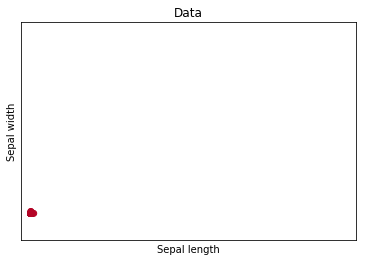

In [68]:
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Data')
plt.show()

C:\Users\femis\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


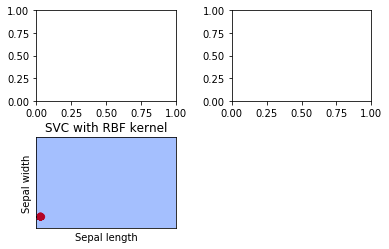

In [81]:
import matplotlib

 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter

svc = SVC(kernel = 'linear', C=C).fit(X_std_pca, y)
rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(X_std_pca, y)
poly_svc = SVC(kernel='poly', degree=3, C=C).fit(X_std_pca, y)
#lin_svc = LinearSVC(C=C).fit(X, y)
 
# create a mesh to plot in
# create a mesh to plot in
x_min, x_max = X_std_pca[:, 0].min() - 1, X_std_pca[:, 0].max() + 1
y_min, y_max = X_std_pca[:, 1].min() - 1, X_std_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))
 
# title for the plots
titles = ['SVC with linear kernel',
'LinearSVC (linear kernel)',
'SVC with RBF kernel',
'SVC with polynomial (degree 3) kernel']
 
for i, clf in enumerate((svc, rbf_svc, poly_svc)):
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
 
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
 
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
 
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title(titles[i])
 
plt.show()

## BoW with Logistic Regression

Let's try a technique with some protection against overfitting due to extraneous features – logistic regression with ridge regularization (from ridge regression, also called L2 regularization).

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\femis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(266, 1613) (266,)
Training set score: 0.9699248120300752

Test set score: 0.8764044943820225


Logistic regression performs a bit better than the random forest.

## BoW with Gradient Boosting

And finally, let's see what gradient boosting can do:

In [9]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.9661654135338346

Test set score: 0.8146067415730337


Looks like LOGISTIC REGRESSION is the winner, but there's room for improvement.

## Same model, new inputs

What if we feed the model a different novel by Jane Austen, like Emma? Will it be able to distinguish Austen from Carroll with the same level of accuracy if we insert a different sample of Austen's writing?

First, we need to process Emma the same way we processed the other data, and combine it with the Alice data. Remember that for computation time concerns, we only took the first tenth of the Alice text. Emma is pretty long. So in order to get comparable length texts, we take the first sixtieth of Emma. Again, if you want to experiment, you can take the whole texts of each.

In [10]:
# Clean the Emma data.
emma = gutenberg.raw('austen-emma.txt')
emma = re.sub(r'VOLUME \w+', '', emma)
emma = re.sub(r'CHAPTER \w+', '', emma)
emma = text_cleaner(emma[:int(len(emma)/60)])
print(emma[:100])

Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to


In [11]:
# Parse our cleaned data.
emma_doc = nlp(emma)

In [12]:
# Group into sentences.
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]

In [13]:
# Build a new Bag of Words data frame for Emma word counts.
# We'll use the same common words from Alice and Persuasion.
emma_sentences = pd.DataFrame(emma_sents)
emma_bow = bow_features(emma_sentences, common_words)

print('done')

Processing row 0
Processing row 50
Processing row 100
Processing row 150
done


In [14]:
# Now we can model it!
# Let's use logistic regression again.

# Combine the Emma sentence data with the Alice data from the test set.
X_Emma_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    emma_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
y_Emma_test = pd.concat([y_train[y_train=='Carroll'],
                         pd.Series(['Austen'] * emma_bow.shape[0])])

# Model.
print('\nTest set score:', lr.score(X_Emma_test, y_Emma_test))
lr_Emma_predicted = lr.predict(X_Emma_test)
pd.crosstab(y_Emma_test, lr_Emma_predicted)


Test set score: 0.7235772357723578


col_0,Austen,Carroll
row_0,,
Austen,158,12
Carroll,56,20


Well look at that! NLP approaches are generally effective on the same type of material as they were trained on. It looks like this model is actually able to differentiate multiple works by Austen from Alice in Wonderland. Now the question is whether the model is very good at identifying Austen, or very good at identifying Alice in Wonderland, or both...

In [15]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']
